In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr  # to read in Zarr format
import gcsfs # to read google cloud data
import momlevel as ml
import cftime
import cmocean
from cartopy import crs as ccrs, feature as cfeature  
import matplotlib.path as mpath

In [ ]:
xr.set_options(display_style='html')
%matplotlib inline                           
%config InlineBackend.figure_format='retina' 
plt.rcParams['figure.figsize'] = 12,6  

In [2]:
def North_Polar(array,vmin,vmax,cmap):
    subplot_kws = dict(projection=ccrs.NorthPolarStereo()) 
    fig, ax = plt.subplots(figsize=[10, 5],subplot_kw=subplot_kws)
    
    array.plot(x='geolon', y='geolat',ax=ax,
               transform =ccrs.PlateCarree(),
               vmin=vmin,
               vmax=vmax,
               extend='both',
               cmap=cmap,levels=30)

    # Limit the map to -50 degrees latitude and below.
    ax.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
    
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)
    ax.coastlines()

In [3]:
def South_Polar(array,vmin,vmax,cmap):
    subplot_kws = dict(projection=ccrs.SouthPolarStereo()) 
    fig, ax = plt.subplots(figsize=[10, 5],subplot_kw=subplot_kws)
    
    array.plot(x='geolon', y='geolat',ax=ax,
               transform =ccrs.PlateCarree(),
               vmin=vmin,
               vmax=vmax,
               extend='both',
               cmap=cmap, levels=30)

    # Limit the map to -50 degrees latitude and below.
    ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)
    ax.coastlines()

### The code in the cell below reads in climate model results stored in the Google Cloud from the GFDL-ESM4 Earth System Model developed at NOAA's Geophysical Fluid Dynamics Laboratory (GFDL). The results are monthly sea ice concentration from the high-emissions future scenario, SSP5-85. A grid cell area file is also loaded in.

In [4]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [5]:
gfdl_esm4_sea_ice_data = df.query(
    "activity_id=='ScenarioMIP' & \
    table_id == 'SImon' & \
    variable_id == 'siconc' & \
    experiment_id == 'ssp585' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4' & \
    grid_label == 'gn' & \
    member_id == 'r1i1p1f1'"
)

# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')
# get the path to a specific zarr store (the first one from the dataframe above)
zstore_siconc = gfdl_esm4_sea_ice_data.zstore.values[-1]
# create a mutable-mapping-style interface to the store
mapper_siconc = gcs.get_mapper(zstore_siconc)
# open the dataset using xarray and zarr
gfdl_esm4_historical_siconc = xr.open_zarr(mapper_siconc, 
                                         consolidated=True,use_cftime=True
                                         ).siconc.rename({'y':'latitude',
                                                             'x':'longitude',
                                                             'lat':'geolat',
                                                             'lon':'geolon'})
gfdl_esm4_historical_siconc

<xarray.DataArray 'siconc' (time: 1032, latitude: 576, longitude: 720)>
dask.array<open_dataset-siconc, shape=(1032, 576, 720), dtype=float32, chunksize=(600, 576, 720), chunktype=numpy.ndarray>
Coordinates:
    geolat     (latitude, longitude) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolon     (latitude, longitude) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * longitude  (longitude) float64 -299.8 -299.2 -298.8 ... 58.75 59.25 59.75
  * latitude   (latitude) float64 -77.91 -77.72 -77.54 ... 89.47 89.68 89.89
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    long_name:      Sea Ice Area Fraction (Ocean Grid)
    original_name:  siconc
    standard_name:  sea_ice_area_fraction
    units:          %

In [6]:
gfdl_esm4_cell_area_data = df.query(
    "activity_id=='CMIP' & \
    table_id == 'Ofx' & \
    variable_id == 'areacello' & \
    experiment_id == 'piControl' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4' & \
    grid_label == 'gn'")

# get the path to a specific zarr store (the first one from the dataframe above)
zstore_area = gfdl_esm4_cell_area_data.zstore.values[-1]
# create a mutable-mapping-style interface to the store
mapper_area = gcs.get_mapper(zstore_area)
# open the dataset using xarray and zarr
gfdl_esm4_cell_area = xr.open_zarr(mapper_area, 
                                         consolidated=True,
                                         ).areacello.rename({'y':'latitude',
                                                             'x':'longitude',
                                                             'lat':'geolat',
                                                             'lon':'geolon'})
gfdl_esm4_cell_area

<xarray.DataArray 'areacello' (latitude: 576, longitude: 720)>
dask.array<open_dataset-areacello, shape=(576, 720), dtype=float32, chunksize=(576, 720), chunktype=numpy.ndarray>
Coordinates:
    geolat     (latitude, longitude) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolon     (latitude, longitude) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
  * longitude  (longitude) float64 -299.8 -299.2 -298.8 ... 58.75 59.25 59.75
  * latitude   (latitude) float64 -77.91 -77.72 -77.54 ... 89.47 89.68 89.89
Attributes:
    cell_methods:   area: sum
    long_name:      Grid-Cell Area
    original_name:  areacello
    standard_name:  cell_area
    units:          m2

### In the cells below present an analysis of Arctic and Antarctic sea ice extent comparing the start of the 21st century (years 2014 to 2025 average) to the end (years 2081 to 2100). Describe your results below. In addition to presenting an effective visualization, your results must be quantitative.

In [7]:
#selecting the years and averaging them
gfdl_1525=gfdl_esm4_historical_siconc.sel(time=slice('2015-01-16', '2025-12-16')).mean(dim='time')
gfdl_81100=gfdl_esm4_historical_siconc.sel(time=slice('2081-01-16', '2100-12-16')).mean(dim='time')

In [8]:
#calculating extent
extent_1525=gfdl_1525*gfdl_esm4_cell_area
extent_81100=gfdl_81100*gfdl_esm4_cell_area

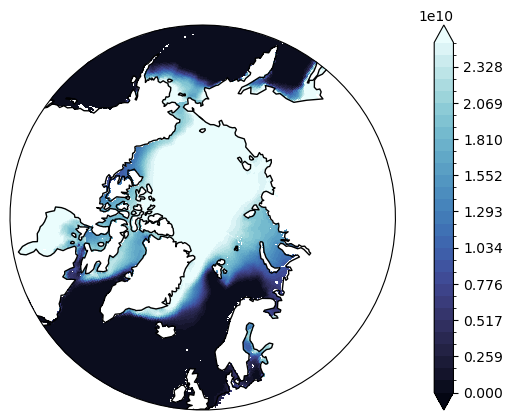

In [9]:
North_Polar(extent_1525, 0, 25000000000, cmocean.cm.ice)

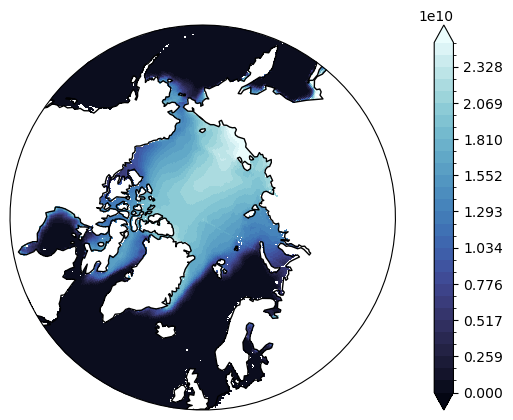

In [10]:
North_Polar(extent_81100, 0, 25000000000, cmocean.cm.ice)

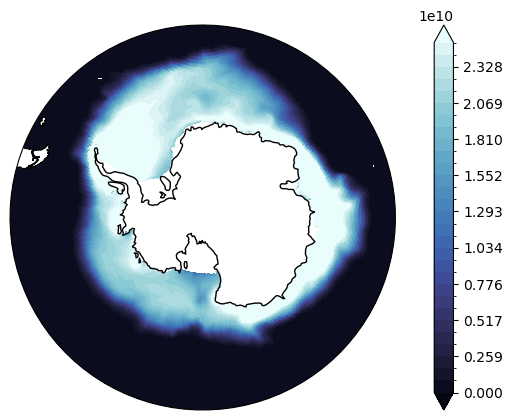

In [11]:
South_Polar(extent_1525, 0, 25000000000, cmocean.cm.ice)

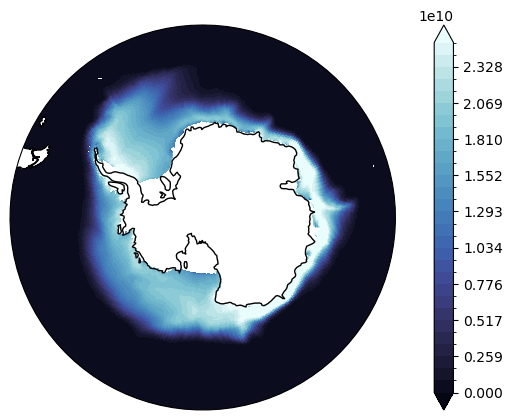

In [12]:
South_Polar(extent_81100, 0, 25000000000, cmocean.cm.ice)

### Compute and produce a timeseries of the Arctic and Antarctic annual mean SIE from 2014 to 2100.

In [13]:
gregorian=gfdl_esm4_historical_siconc.convert_calendar('Gregorian')

In [14]:
#annual average
annual_15100=gregorian.groupby('time.year').mean(dim='time')

In [15]:
#converting to extent
extent_15100=annual_15100*gfdl_esm4_cell_area

In [16]:
arctic_15100=extent_15100.sel(latitude=slice(-77.91,0))
antarctic_15100=extent_15100.sel(latitude=slice(0,89.89))

In [17]:
#averaging lat and lon to get a time series
avg_arc_extenet_15100= arctic_15100.mean(dim=['latitude','longitude'])
avg_ant_extent_15100= antarctic_15100.mean(dim=['latitude','longitude'])

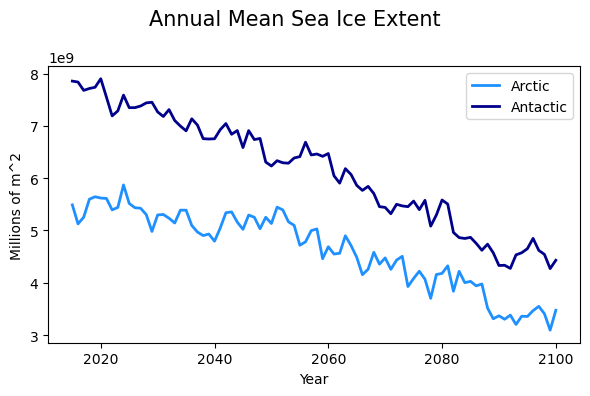

In [18]:
fig, (ax) = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 4))

fig.suptitle('Annual Mean Sea Ice Extent', fontsize=15)

ax.plot(avg_arc_extenet_15100['year'], avg_arc_extenet_15100, linewidth=2, 
        label='Arctic', color='dodgerblue')
ax.plot(avg_ant_extent_15100['year'], avg_ant_extent_15100, linewidth=2, 
        label='Antactic', color='darkblue')

ax.legend()
ax.set_ylabel('Millions of m^2')
ax.set_xlabel('Year')

plt.tight_layout()

#### Note that due to a bug in Xarray dealing with a NOLEAP calendar, you must convert the calendar to Gregorian prior to plotting ....

#### `data_array.convert_calendar('Gregorian').plot()`

### Produce effective visualizations of the spatial changes in Arctic and Antarctic sea ice concentration at the end of the century vs. the start. Describe the patterns in the cell below. Note that the North Pole looks distorted in the model data .... this is because climate models actually have 3 poles .... a "tri-polar" grid, due to computational difficulties with solving equations converging on a single point.

### Read the following tutorial and work through the use of `geolon` and `geolat` in the `.plot()` method to produce the correct non-distorted Antarctic.

### All differences should be computed as `last - first`.

Viz: last 50 years-first 50 years, last 10 years-first 10, last year- first year

In [19]:
#last 50 years- first 50 years
lastyear=gfdl_esm4_historical_siconc.sel(time=slice('2100-01-16', '2100-12-16')).mean(dim='time')
lastyear_ex=lastyear*gfdl_esm4_cell_area

firstyear=gfdl_esm4_historical_siconc.sel(time=slice('2015-01-16', '2015-12-16')).mean(dim='time')
firstyear_ex=firstyear*gfdl_esm4_cell_area

difference_1year=lastyear_ex-firstyear_ex

In [20]:
#plot_color_gradients('Diverging',
                     #['PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu',
                      #'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic'])
from colorspacious import cspace_converter
cmaps = {}

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
    fig, axs = plt.subplots(nrows=nrows + 1, figsize=(6.4, figh))
    fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                        left=0.2, right=0.99)
    axs[0].set_title(f'{category} colormaps', fontsize=14)

    for ax, name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=mpl.colormaps[name])
        ax.text(-0.01, 0.5, name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()

    # Save colormap list for later.
    cmaps[category] = cmap_list

In [21]:
North_Polar(difference_1year, -4, 4, plot_color_gradients('Diverging', ['PiYG'])

SyntaxError: unexpected EOF while parsing (1521712821.py, line 1)

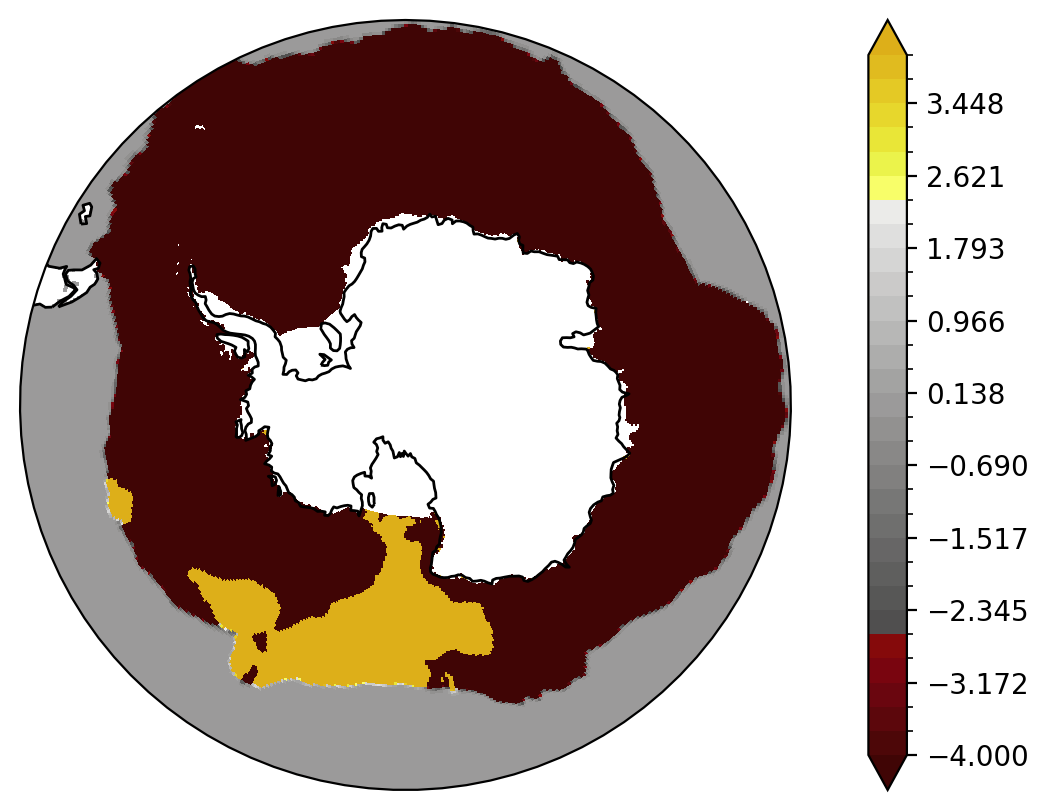

In [89]:
South_Polar(difference_1year, -4, 4, cmocean.cm.oxy)

In [71]:
#last 10 years - first 10 years

last10=gfdl_esm4_historical_siconc.sel(time=slice('2090-01-16', '2100-12-16')).mean(dim='time')
last10_ex=last10*gfdl_esm4_cell_area

first10=gfdl_esm4_historical_siconc.sel(time=slice('2015-01-16', '2025-12-16')).mean(dim='time')
first10_ex=first10*gfdl_esm4_cell_area

difference_10year=last10_ex-first10_ex

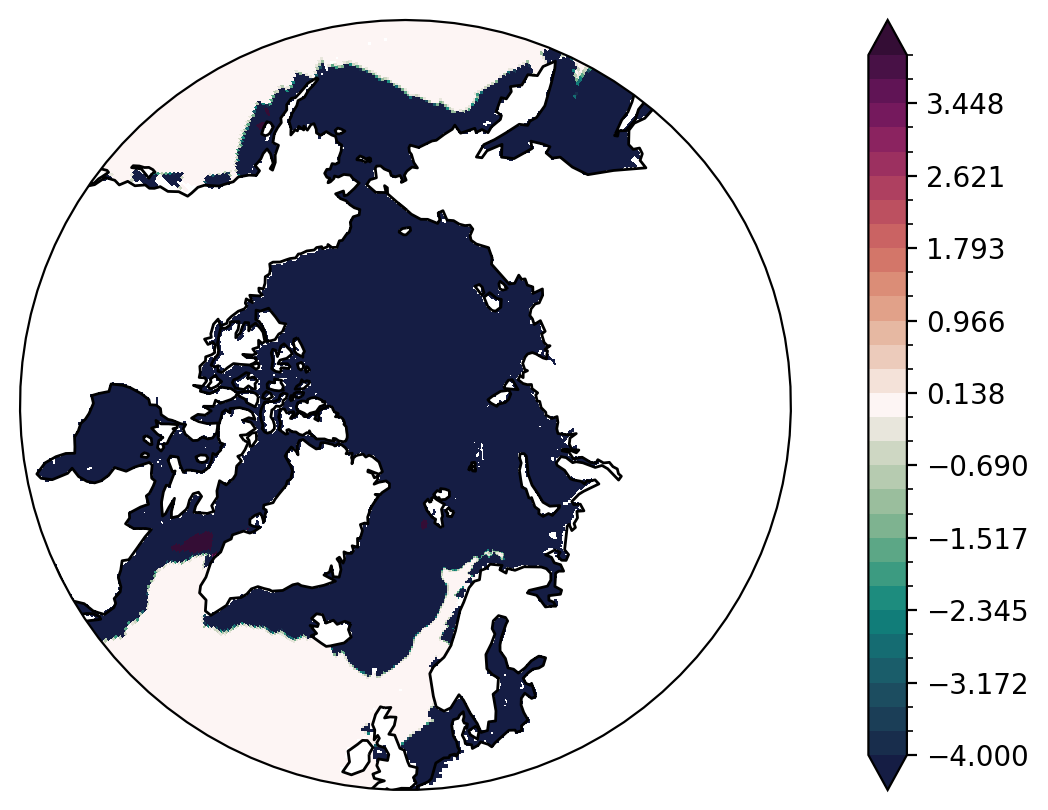

In [85]:
North_Polar(difference_10year, -4, 4, cmocean.cm.curl)

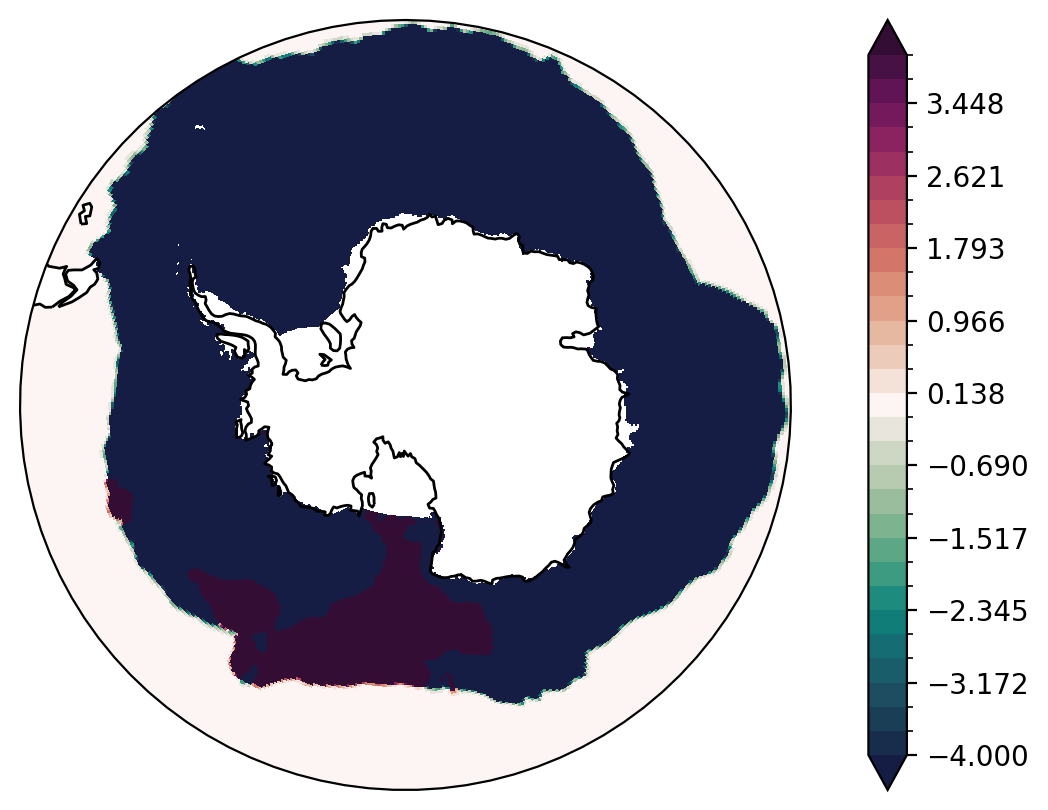

In [81]:
South_Polar(difference_10year, -4, 4, cmocean.cm.curl)